<a href="https://colab.research.google.com/github/vondersam/sdgs_text_classifier/blob/master/experiments/sdgs_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install PyDrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
pre = drive.CreateFile({'id':'1ojX1O9ifhZdT78l5mcD-Ctx6yapF7T5o'})
pre.GetContentFile('preprocess.ipynb')

In [0]:
from preprocessing import count_mas

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
base_dir = "gdrive/My Drive/fastai-v3/sdgs/"
dataset_dir = base_dir + "lstm/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from fastai.text import *

## Uploading the data

In [0]:
source_path = Path(dataset_dir + 'cleanup_labelled.csv')
df = pd.read_csv(source_path)
df.head()

,text,labels,doc_id
0,Goal 8: Decent work and economic growth,8,downloadable_pdfs/http:__www.dev.sdgfund.org_%...
1,The day after receiving the 2016 Pritzker Laur...,11,downloadable_pdfs/http:__www.dev.sdgfund.org_a...
2,"For Paloma Duran, SDG Fund director, this proj...",16,downloadable_pdfs/http:__www.dev.sdgfund.org_b...
3,"Rangita de Silva, Associate Dean of the Univer...",5,downloadable_pdfs/http:__www.dev.sdgfund.org_b...
4,"The SDG Fund, an interagency mechanism establi...",16,downloadable_pdfs/http:__www.dev.sdgfund.org_b...


We first create a general language model with the unlabelled data, which we will later fit into the WikiText 103 language model, so that it has more information about SDGs.

In [0]:
#data_lm = TextLMDataBunch.from_csv(dataset_dir, 'cleanup_unlabelled.csv')

In [0]:
#data_lm.show_batch()
#data_lm.save('data_lm_export.pkl')
path = Path(dataset_dir)
data_lm = load_data(path, 'data_lm_export.pkl')

# Training the general language model

We train on the first layer of the language model with all the data and a pretrained language model from the WikiText 103. This is included in the architecture of AWD_LSTM.

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


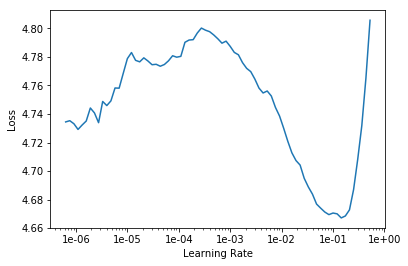

In [0]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [0]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.683069,3.525900,0.373216,53:59


In [0]:
#learn.save('fit_head')

In [0]:
learn.load('fit_head')

In [0]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.377476,3.319256,0.397248,30:46
1,3.279190,3.227974,0.410936,31:02
2,3.206759,3.170761,0.419910,31:04
3,3.134039,3.119085,0.427909,31:03


Buffered data was truncated after reaching the output size limit.

In [0]:
#learn.save_encoder('fine_tuned_encoder')

In [0]:
learn.load_encoder('fine_tuned_encoder')

In [7]:
learn.predict("African countries like", n_words=20)

'African countries like Kenya , Liberia , and Madagascar rejected any lobbying constituents establish a leida certification deal without democratic'

# Training the classifier

Then we load the language model for the classifier

In [0]:
data_clas = TextClasDataBunch.from_csv(dataset_dir, 'cleanup_labelled.csv', vocab=data_lm.train_ds.vocab, bs=32, text_cols='text', label_cols="labels", label_delim="|")

In [0]:
#data_clas.save('data_clas_export.pkl')

In [0]:
#data_clas = load_data(path, 'data_clas_export.pkl', bs=16)

In [0]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)

F1macro = partial(MultiLabelFbeta, average="macro")
F1micro = partial(MultiLabelFbeta, average="micro")
F1weighted = partial(MultiLabelFbeta, average="weighted")

learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics=[acc_02, f_score], callback_fns=[F1macro, F1micro, F1weighted])
learn.load_encoder('ft_enc')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


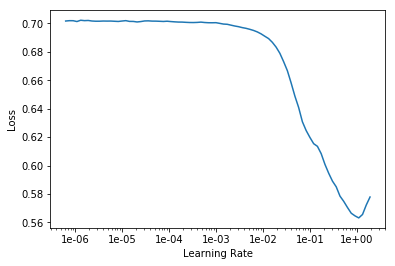

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, 3e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,macro_fbeta,micro_fbeta,weighted_fbeta,time
0,0.281346,0.248257,0.912871,0.238434,0.159213,0.163926,0.164260,00:13


In [0]:
#learn.save('first')

In [0]:
learn.load('first')

In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,macro_fbeta,micro_fbeta,weighted_fbeta,time
0,0.231646,0.212196,0.910602,0.434260,0.229493,0.251029,0.243056,00:18


In [0]:
#learn.save('second')

In [0]:
lear.load('second')

In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,macro_fbeta,micro_fbeta,weighted_fbeta,time
0,0.189830,0.172758,0.927903,0.558958,0.417611,0.439797,0.433209,00:29


In [0]:
#learn.save('third')

In [0]:
learn.load('third')

In [138]:
# With a learning rate of slice(1e-3/(2.6**4),1e-3)
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-3/(2.6**4),1e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,macro_fbeta,micro_fbeta,weighted_fbeta,time
0,0.172672,0.141480,0.942368,0.651485,0.518233,0.537711,0.532352,00:37
1,0.166876,0.130341,0.946736,0.686638,0.542066,0.561613,0.557383,00:37
2,0.155276,0.119334,0.948381,0.722205,0.592623,0.609693,0.606967,00:33
3,0.137068,0.108220,0.950536,0.761512,0.653512,0.669546,0.667487,00:37
4,0.124732,0.102169,0.959555,0.754932,0.693278,0.707567,0.705848,00:35
5,0.115931,0.091881,0.961087,0.799819,0.731364,0.742160,0.741121,00:32
6,0.100891,0.090781,0.959215,0.801923,0.759918,0.770815,0.769982,00:36
7,0.094499,0.086229,0.962902,0.805406,0.778628,0.787539,0.787031,00:31
8,0.093398,0.087269,0.959102,0.802310,0.779061,0.788544,0.788034,00:30
9,0.091187,0.087756,0.959045,0.799208,0.787053,0.796778,0.796169,00:29


In [0]:
learn.save('fourth')

In [0]:
#learn.load('fourth')

In [146]:
# With a learning rate of slice (1e-3/(2.6**4),5e-3) and (1e-3/(2.6**4),3e-3), it overfits, so we train another batch of 6 epochs. After 6 epochs it starts overfitting
learn.unfreeze()
learn.fit_one_cycle(6, slice(1e-3/(2.6**4),1e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,macro_fbeta,micro_fbeta,weighted_fbeta,time
0,0.056034,0.071270,0.967837,0.832959,0.866857,0.872414,0.872303,00:32
1,0.058651,0.073037,0.971070,0.831064,0.865206,0.870782,0.870655,00:28
2,0.052649,0.070634,0.968801,0.839224,0.881514,0.886660,0.886561,00:34
3,0.050444,0.070131,0.973283,0.839401,0.881124,0.885314,0.885232,00:34
4,0.046214,0.070047,0.973623,0.840824,0.894827,0.898817,0.898765,00:36
5,0.043697,0.070427,0.972545,0.838925,0.896308,0.899489,0.899420,00:36


In [0]:
learn.save('fifth')

In [0]:
#learn.load('fifth')

In [154]:
learn.show_results(rows=500)

text,target,prediction
"xxbos xxup unossc , nest , xxmaj southern xxmaj voice , xxmaj reality of xxmaj aid , xxup undp and xxmaj mexico xxmaj south - xxmaj south cooperation ( xxup ssc ) has played an ever - increasing role in overcoming national , regional and global developmental challenges and is now a key enabler for achieving 2030 xxmaj agenda and other xxmaj internationally xxmaj agreed xxmaj development xxmaj goals .",5,
"xxbos xxup unops , xxmaj republic of xxmaj slovenia and xxup un - xxup ece xxmaj background xxmaj the xxmaj united xxmaj nations 2030 xxmaj agenda emphasizes the role that innovation plays in support of sustainable development . xxmaj an important emerging innovation that has been in the news recently is blockchain / distributed xxunk technology . xxmaj originally , the blockchain ’s primary use of blockchain technology was to",12;2,2
"xxbos xxmaj table 3 : xxmaj targets and indicators for xxup sdg 11 xxmaj target description xxmaj core indicator xxmaj tier 11.1 xxmaj by 2030 , ensure access for all to adequate , safe and affordable housing and basic services and upgrade slums xxunk xxmaj proportion of urban population living in slums , informal settlements or inadequate housing i 11.2 xxmaj by 2030 , provide access to safe , affordable",1;11,1;11
"xxbos xxmaj china , xxmaj korea and xxmaj singapore defined goals with underlying targets and indicators . xxmaj china aims at “ building a water - saving society ” ( xxmaj national xxmaj development and xxmaj reform xxmaj commission of xxmaj china , 2011 ) , xxmaj korea plans to increase the efficiency and equity of water management through an improved water pricing system and xxmaj singapore aims for self",9,
"xxbos xxmaj permanent xxmaj missions of xxmaj denmark and xxmaj colombia , xxup un - xxup desa xxmaj statistical xxmaj division xxmaj supported by xxmaj statistics xxmaj denmark , xxmaj xxunk xxmaj xxunk , xxmaj novo xxmaj xxunk a / s xxmaj background xxmaj three years after the xxmaj sustainable xxmaj development xxmaj goals ( sdgs ) have been adopted , a growing number of stakeholders recognise that the fulfilment",17,17
"xxbos xxmaj in discussing the xxmaj sahara xxmaj foundation ’s work engaging the private sector in supporting the sdgs , xxmaj xxunk said : “ xxmaj what we realized is that a lot of private - sector companies want to do good , but require the right partners and an enabling environment . xxunk xxmaj in many cases , it will be possible to make a positive case that contributing",16,16
"xxbos 31 xxmaj for xxup sdg1 in xxmaj africa , xxup rri has roles in probing the magnitude of the key factors feeding the incidence and depth of poverty in the region including high income inequality and illiteracy . xxmaj on the other hand , the key drivers that significantly reduce poverty in the region will need to be collectively probed through xxup rri . xxmaj these include higher levels",2;3,1;2;3
"xxbos xxmaj by committing to xxmaj sustainable xxmaj development xxmaj goal 16 , xxup un member states agreed to track and report data about the closely related issues of peace , justice , and inclusion . xxmaj these are among the more difficult issues in the sdgs to quantify , and are often difficult to measure easily or cheaply . xxmaj for many states , meeting their commitments to report",16,16
"xxbos xxmaj if governance can not provide better means of making trade - offs across issues , regions , groups , and time horizons , sustainable development will be hard to achieve . xxmaj because these elements are absent from xxup sdg 16 , it falls short of what the evidence suggests is needed . xxmaj moreover , because the xxup sdg 16 elements point a spotlight overwhelmingly on poor",16,16
"xxbos xxmaj an analysis of 100 epzs and a xxmaj framework for xxmaj sustainable xxmaj economic xxmaj zones 1 . xxmaj introduction xxmaj historically , the relationship between industrialization , international trade and sustainable development has been xxunk xxmaj lau

## GPU information

Get information on the machine the experiment is run

In [0]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [0]:
from fastai.utils.show_install import *
show_install()

## Evaluate results using Scikit Learn

In [0]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import classification_report
y_pred, y_true = learn.get_preds()

In [0]:
y_true = y_true.numpy()
y_pred = y_pred.numpy()

In [0]:
threshold = 0.3

In [153]:
metrics = classification_report(y_true, y_pred>threshold, target_names=data_clas.valid_ds.classes)
print(metrics)

              precision    recall  f1-score   support

           1       0.87      0.88      0.87        88
          10       0.65      0.69      0.67        52
          11       0.84      0.82      0.83        82
          12       0.75      0.87      0.81        55
          13       0.83      0.91      0.87        70
          14       0.94      0.91      0.93       112
          15       0.88      0.86      0.87        66
          16       0.82      0.86      0.84        92
          17       0.93      0.79      0.85       117
           2       0.81      0.74      0.77        85
           3       0.82      0.86      0.84       105
           4       0.88      0.93      0.90        80
           5       0.80      0.76      0.78        97
           6       0.86      0.90      0.88        70
           7       0.92      0.95      0.93        82
           8       0.86      0.82      0.84        83
           9       0.92      0.67      0.78        70

   micro avg       0.85   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
